__Нейросетевая языковая модель на основе схемы Seq2Seq__

Евгений Борисов <esborisov@sevsu.ru>

---

# загружаем тексты

In [1]:
import gzip
import requests
from bs4 import BeautifulSoup

In [2]:
# url='http://lib.ru/NEWPROZA/LOBAS/taxisty.txt'
# text = BeautifulSoup(requests.get(url).text).get_text()
# with gzip.open('taxisty.txt.gz','wt') as f: f.write(text)

with gzip.open('taxisty.txt.gz','rt') as f: text = f.read()

text = text[1030:-7261].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:343])

символов:637765
---------------

Вы прилетели в  Нью-Йорк и  остановились  в  одном  из отелей, глядящих
окнами на Центральный парк.  Наутро по  приезде вы вышли из  отеля, вдохнули
полной грудью очищенный зеленью парка воздух  и,  взглянув на часы, --  пора
было начинать хлопотливый день, --  направились к  первому из  таксомоторов,
выстроившихся вереницей у подъезда.
    


In [3]:
# url='http://az.lib.ru/d/dostoewskij_f_m/text_0080.shtml'
# text = BeautifulSoup(requests.get(url).text).get_text()
# with gzip.open('dostoewskij.txt.gz','wt') as f: f.write(text)

# # with gzip.open('dostoewskij.txt.gz','rt') as f: text = f.read()

# text = text[2876:-664184].strip() # выкидываем заголовок и хвост страницы 
# print(f'символов:{len(text)}\n---------------\n'%())
# print(text[:355])

---

In [4]:
from tqdm.auto import tqdm
from itertools import chain
import numpy as np

In [5]:
from nltk import __version__ as nltk_version
print('nltk version:',nltk_version)

from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.util import ngrams

nltk version: 3.8.1


In [6]:
# !pip install torch

In [7]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

In [8]:
# !pip install torchtext

In [9]:
# import torchtext
# from torchtext.data import get_tokenizer

In [10]:
class SeqDataset(Dataset):
    
    def __init__(self, text, seq_len=5 ):
        assert seq_len>1
        assert len(text)>1
        
        self._tokens = ['<UNK>','<EOS>',] # служебные токены "неизвестное слово", "конец последовательности"
        
        self._seq_len = seq_len # количество слов контекста слева 
        
        # выполняем токенизацию текста 
        self._sentences = [ 
            nltk_tokenize_word(s,language='russian') # разбиваем предложения на слова
            for s in tqdm(nltk_sentence_split(text,language='russian')) # режем текст на отдельные предложения
        ]
        # строим словарь
        self._vocabulary = self._build_vocabulary(self._sentences)
        # выкидываем короткие предложения, добавляем служебный токен "конец последовательности"
        self._sentences = [ s + [ '<EOS>' ] for s in self._sentences if len(s)> self._seq_len*2 ]
        # собираем n-граммы длинны context_len+1
        self._data = self._encode_ngrams( self._build_ngrams(self._sentences) )
        
    def _build_vocabulary(self,sentences):        
        # собираем токены (слова) из текста, добавляем служебные
        text_tokens = self._tokens + sorted( set(chain(*sentences))-set(self._tokens) ) 
        return { w:n for n,w in enumerate(text_tokens) } # строим словарь
    
    def _build_ngrams(self, sentences):
        return [ # нарезаем последовательности токенов на n-граммы
            ng for s in tqdm(sentences)  
               for ng in ngrams( s, self._seq_len*2 ) 
        ]
    
    def _encode_ngrams(self,ngrams): # заменяем токены в n-граммах на номера в словаре
        return torch.tensor([ self.encode(ng) for ng in tqdm(ngrams) ], dtype=torch.long ) 
    
    def encode(self,s): return [ # заменить в последовательности все токены на их номера в словаре
            self._vocabulary[w] if (w in self._vocabulary) else self._vocabulary['<UNK>']
            for w in s 
        ]
    
    def __getitem__(self, idx): # выдать элемент датасета номер idx
        return ( 
                self._data[idx,:self._seq_len], 
                self._data[idx,self._seq_len:], 
            )
    
#     def _num2vec(self,x): # заменяем номер слова на вектор [0,1] длинны в размер словаря
#         return F.one_hot( x, num_classes=len(self._vocabulary)).to( torch.float32 ) 

    # размер датасета
    def __len__(self): return len(self._data)
    
    @property
    def vocabulary(self): return self._vocabulary
    
    @property
    def sentences(self): return self._sentences
    
    @property
    def sentence_len(self): return self._seq_len

In [11]:
ds = SeqDataset( text=text )

  0%|          | 0/6650 [00:00<?, ?it/s]

  0%|          | 0/3754 [00:00<?, ?it/s]

  0%|          | 0/69399 [00:00<?, ?it/s]

In [12]:
display(len(ds)) # размер датасета
display(len(ds.sentences)) # количество предложений 
display(len(ds.vocabulary)) # размер словаря
display(max(ds.vocabulary.values())) # максимальное значение индекса в словаре

69399

3754

24068

24067

In [13]:
assert len(ds.vocabulary)== max(ds.vocabulary.values())+1

In [14]:
ds[:2]

(tensor([[  731, 17216,  4595,  1980,  9159],
         [17216,  4595,  1980,  9159, 13906]]),
 tensor([[13906,  4595, 13485,  9212, 14087],
         [ 4595, 13485,  9212, 14087,    14]]))

# модель

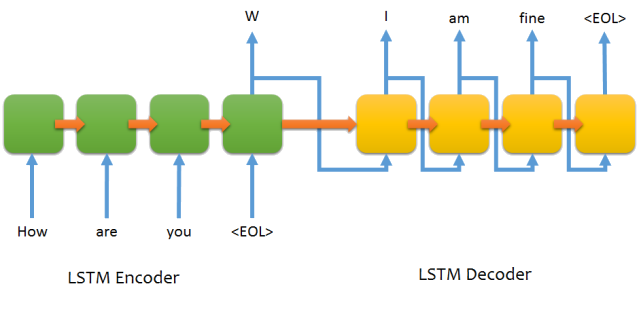

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class Encoder(nn.Module):
    def __init__(self, vocabulary, embedding_dim=128, hidden_dim=256,): 
        super().__init__()
        self._vocabulary = vocabulary
        self._emb = nn.Embedding(len(vocabulary), embedding_dim)
        self._gru = nn.GRU(
                input_size=embedding_dim, 
                hidden_size=hidden_dim, 
                num_layers=1, 
                batch_first=True,
                # dropout=0.4,
            )

    def forward(self, x):
        o = self._emb(x)
        o, h = self._gru(o)
        return o,h

In [17]:
class Decoder(nn.Module):
    
    def __init__(self, vocabulary, hidden_dim):
        super(Decoder, self).__init__()
        self._vocabulary = vocabulary
        
        self._emb = nn.Embedding(num_embeddings=len(vocabulary),embedding_dim=hidden_dim)
        self._gru = nn.GRU( 
                input_size=hidden_dim, 
                hidden_size=hidden_dim, 
                num_layers=1, 
                batch_first=True,
                # dropout=0.4,
            )
        self._lin = nn.Linear(in_features=hidden_dim, out_features=len(vocabulary),bias=True,)

    # генерируем выход модели
    def _forward_step(self,x,h):
        o = self._emb(x)
        o,h = self._gru(o,h)
        o = self._lin(o)
        o = F.log_softmax(o,dim=-1)
        return o,h
    
    # рабочий режим - по авторегрессионной схеме генерируем последовательность длиной seq_len
    def forward(self, encoder_hidden, seq_len=10): 
        device = next(self._lin.parameters()).device # устройство модели
        batch_size = encoder_hidden.size(1) # размер входного батча 
        codes = [] # выходная последовательность
        h = encoder_hidden # состояние энкодера передаём декодеру
        # начальный вход рекуррентного слоя
        o = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
        for i in range(seq_len):
            o, h  = self._forward_step(o,h) # авторегрессионная схема - выход подаём на вход
            o = torch.argmax(o,dim=-1, keepdim=False) # определяем номер токена-победителя
            codes.append(o.cpu().numpy()) # сохраняем результат
        return np.hstack(codes)
                
    # учебный режим - генерируем последовательность длинной как у target
    # по схеме teacher forcing, на каждой итерации заменяем вход на значение из target
    def forward_train(self, encoder_hidden, target):
        device = next(self._lin.parameters()).device # устройство модели
        batch_size = encoder_hidden.size(1) # размер входного батча 
        seq_len = target.size(-1) # длина учебной последовательности
        
        outputs = []  # выходы модели 

        # начальный вход рекуррентного слоя
        t = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
        h = encoder_hidden  # состояние энкодера передаём декодеру
        
        for i in range(seq_len):
            o, h = self._forward_step(t,h)
            outputs.append(o)
            # teacher forcing: заменяем выход модели на предыдущей итерации на target
            t = target[:,[i]].to(device)
        return torch.cat(outputs, dim=1)
    

In [18]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Tesla P40'

In [19]:
embedding_dim = 128
encoder_hidden_dim = 256

model_encoder = Encoder(
        vocabulary=ds.vocabulary, 
        embedding_dim=embedding_dim,
        hidden_dim=encoder_hidden_dim,
    ).to(device)

model_decoder = Decoder( 
        vocabulary=ds.vocabulary, 
        hidden_dim=encoder_hidden_dim, 
    ).to(device)

In [20]:
# x,t = ds[:2]
# with torch.set_grad_enabled(False): # генерируем следующий токен
#     _,h = Encoder(vocabulary=ds.vocabulary, embedding_dim=128, hidden_dim=256,).forward(x)
#     display(h.shape)
#     o = Decoder(vocabulary=ds.vocabulary, hidden_dim=256, ).forward_train(h,t)
#     display(o.shape)
#     c = Decoder(vocabulary=ds.vocabulary, hidden_dim=256,).forward(h)
#     display(c.shape)

# обучаем 

In [21]:
from torch import optim

learning_rate = 1e-3
encoder_optimizer = optim.Adam( model_encoder.parameters(), lr=learning_rate )
decoder_optimizer = optim.Adam( model_decoder.parameters(), lr=learning_rate )
criterion = nn.NLLLoss()

In [22]:
# история значений ф-ции потери
loss_history = [] 

In [23]:
from torch.utils.data import DataLoader

In [24]:
%%time

n_epoch = 64 # количество эпох обучения
batch_size = 1024

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    
    # получаем батч учебных примеров
    for encoder_input_, target in DataLoader( ds, batch_size=batch_size, shuffle=True): 
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        _, encoder_hidden = model_encoder(encoder_input_.to(device))
        decoder_outputs = model_decoder.forward_train( encoder_hidden, target )
        
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target.to(device).view(-1)
        )
        loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
   
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери


  0%|          | 0/64 [00:00<?, ?it/s]

CPU times: user 4min 49s, sys: 385 ms, total: 4min 49s
Wall time: 4min 42s


Text(0.5, 1.0, 'min loss: 0.03092')

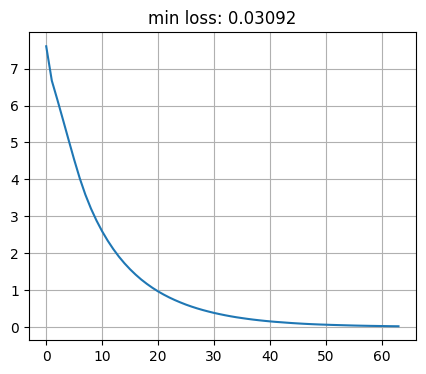

In [25]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(loss_history)
ax.grid()
ax.set_title(f'min loss: {min(loss_history):.5f}')

# тестируем

In [26]:
from random import sample
from nltk.util import ngrams 

prompts = [
    ' '.join(ng) 
    for s in sample( ds.sentences,10 ) if len(s)>ds.sentence_len*2
    for ng in list(ngrams(s[:ds.sentence_len],ds.sentence_len))  
    ]

display( prompts )

['Я открыл замок , и',
 'Так заключенные , выйдя на',
 'Я же ехал помедленней ,',
 'С видимым удовольствием вращал кулак',
 'Мог вообще не поехать на',
 'После легких аэропортовских долларов поработать',
 'С тех пор , после',
 'Теперь из студии записи я',
 'В операционной вивария собакам вживляли',
 'А сколько полагается швейцару за']

In [27]:
class LangModelSeq2Seq: # генератор текста 
    
    def __init__(self,encoder,decoder,vocabulary):
        self._encoder = encoder 
        self._decoder = decoder 
        self._vocabulary = vocabulary # словарь языковой модели
        self._vocabulary_inv = { v:k for k,v in self._vocabulary.items() }
    
    def predict(self,prompt,seq_len=10):
        codes = self._predict( self._encode(prompt), seq_len) # генерируем коды токенов
        return self._strip_eos( self._decode(np.hstack(codes)) ) # конвертируем коды токенов в строку
    
    def _predict(self,x,seq_len):
        device = next(self._encoder.parameters()).device 
        with torch.set_grad_enabled(False): # генерируем следующий токен
            _,h = self._encoder(x.to(device))
            codes = self._decoder.forward(h,seq_len)
        return codes
    
    def _encode(self,s): # кодируем строку
        s = nltk_tokenize_word(s,language='russian')
        s = [ self._vocabulary[w] for w in s if (w in self._vocabulary) ]
        return torch.tensor([s], dtype=torch.long )
    
    def _decode(self,s): # конвертируем коды токенов в строку
        return ' '.join([ 
            self._vocabulary_inv[c] 
            for c in s if (c in self._vocabulary_inv) 
        ])
    
    @staticmethod
    def _strip_eos(s, eos = '<EOS>'):
        n = s.find(eos)
        return s if n<0 else s[:n+len(eos)]

In [28]:
generator = LangModelSeq2Seq(model_encoder,model_decoder,ds.vocabulary)

for prompt in prompts:
    t = generator.predict(prompt,seq_len=35)
    print(prompt,'==>', t,'\n')

Я открыл замок , и ==> , пока губошлеп усаживался , сказал : `` О ! <EOS> 

Так заключенные , выйдя на ==> волю , тоскуют по лагерю ... Но Миша на нем ? <EOS> 

Я же ехал помедленней , ==> следя за мальчишкой , миновал всего ожидать можно . <EOS> 

С видимым удовольствием вращал кулак ==> , сжимал и разжимал пальцы . <EOS> 

Мог вообще не поехать на ==> работу , устроить себе внеочередное воскресенье . <EOS> 

После легких аэропортовских долларов поработать ==> еще часика три-четыре , чтоб дотянуть до спора на счетчике вскрытие сомкнутых крыше солнце солнце огромной солнце огромной солнце огромной солнце огромной солнце огромной солнце огромной солнце огромной солнце огромной солнце огромной солнце огромной солнце 

С тех пор , после ==> памятного этого случая , я видел этого и не видел . <EOS> 

Теперь из студии записи я ==> выходил окрыленным , и все предупреждения редактора , как все время наезжал на бровку . <EOS> 

В операционной вивария собакам вживляли ==> в мозг особые имитирую